In [ ]:
!pip install 'qiskit[visualization]'
!pip install qiskit-ibm-runtime
!pip install qiskit-aer


In [ ]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
#
from scipy.optimize import minimize
#
from qiskit.quantum_info import SparsePauliOp
#
from qiskit.circuit.library import QAOAAnsatz

#
from qiskit import transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

#
from qiskit_aer import AerSimulator
#
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit_aer.primitives import SamplerV2 as Sampler

from tqdm import tqdm

print('import done')

import done


In [ ]:
# S1 = {x1, x2}, S2 = {x1}
exact_cover_paulis = [('IZ', -0.5), ('ZZ', 0.5)]
# S1 = {x1, x2}, S2 = {}
# exact_cover_paulis = [('IZ', -1)]
# S1 = {x1}, S2 = {x2}
# exact_cover_paulis = [('ZI', -0.5), ('IZ', -0.5)]
# S1 = {x1, x2}, S2 = {x1, x2}
# exact_cover_paulis = [('ZZ', 1)]

# exact_cover_paulis_list = [[('IZ', -0.5), ('ZZ', 0.5)], [('IZ', -1)], [('ZI', -0.5), ('IZ', -0.5)], [('ZZ', 1)]]

cost_hamiltonian_ec = SparsePauliOp.from_list(exact_cover_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian_ec)


Cost Function Hamiltonian: SparsePauliOp(['ZZ'],
              coeffs=[1.+0.j])


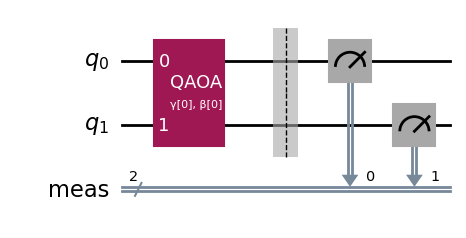

In [ ]:
layers = 1
circuit_exact_cover = QAOAAnsatz(cost_operator=cost_hamiltonian_ec, reps=layers)
circuit_exact_cover.measure_all()
circuit_exact_cover.draw('mpl')



In [ ]:
print(circuit_exact_cover.parameters)

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(γ[0])])


In [ ]:
# define 'helper functions'


# Estimate the cost of a given configuration
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs
    return cost



In [ ]:
# 1 layer simulation
sim = AerSimulator()
# transpile the abstract circuit to a circuit that fit the simulator/machine
ansatz = transpile(circuit_exact_cover, sim, optimization_level=0)
# circuit parameters
estimator = Estimator()
hamiltonian = cost_hamiltonian_ec

# Resolution of gamma and beta. larger number = finer resolution/more samples
# Note: aproximate time to run this cell on my machine
# 100x100 takes ca 4317 min
# 40x40   takes ca 3 min
# 20x20   takes ca 30 sec
# 10x10   takes ca 10 sec
# n_gamma = 21
# n_beta = 21
n_gamma = 61
n_beta = 61

# gamma, beta \in [0,pi]
# Note: max-cut has a symetry so that [0, pi/2] is suficient
gammas = np.linspace(0, np.pi, num=n_gamma)
betas = np.linspace(0, np.pi, num=n_beta)


# Sweep over gamma and beta and compute the expected cost for each optimal configuration
optimized_sols:list[dict]=[]
opt_vals = np.zeros((n_gamma, n_beta))
for ig in tqdm(range(n_gamma)):
    for jb in range(n_beta):
        params = [gammas[ig],betas[jb]]
        opt_vals[ig, jb] = cost_func_estimator(params, ansatz, hamiltonian, estimator)








100%|██████████| 61/61 [01:31<00:00,  1.50s/it]


In [ ]:
# print(result)
print(opt_vals[:5])

[[ 4.49218750e-02  2.34375000e-02 -1.75781250e-02  1.95312500e-02
  -1.95312500e-03 -7.61718750e-02 -2.14843750e-02  9.76562500e-03
  -9.76562500e-03  3.12500000e-02  2.34375000e-02 -4.49218750e-02
  -2.14843750e-02 -1.56250000e-02 -3.12500000e-02 -2.53906250e-02
   2.34375000e-02 -2.73437500e-02  8.59375000e-02 -1.95312500e-03
   6.83593750e-02 -3.46944695e-18 -1.75781250e-02 -3.12500000e-02
   7.81250000e-03  1.95312500e-03 -4.10156250e-02  1.75781250e-02
  -1.56250000e-02 -3.51562500e-02 -2.34375000e-02  1.36718750e-02
  -4.49218750e-02 -4.68750000e-02 -3.51562500e-02  1.56250000e-02
   5.07812500e-02 -1.17187500e-02 -2.92968750e-02 -1.75781250e-02
  -1.36718750e-02  0.00000000e+00 -5.85937500e-03  1.95312500e-02
  -1.17187500e-02 -1.75781250e-02 -2.14843750e-02 -9.76562500e-03
  -1.17187500e-02  6.93889390e-18 -1.75781250e-02  2.53906250e-02
   3.90625000e-03 -3.32031250e-02  3.90625000e-02  1.95312500e-02
   1.17187500e-02 -5.07812500e-02  2.14843750e-02 -2.73437500e-02
   1.56250

Text(0.5, 1.0, 'Expected Cost over the $\\beta$,$\\gamma$-plane')

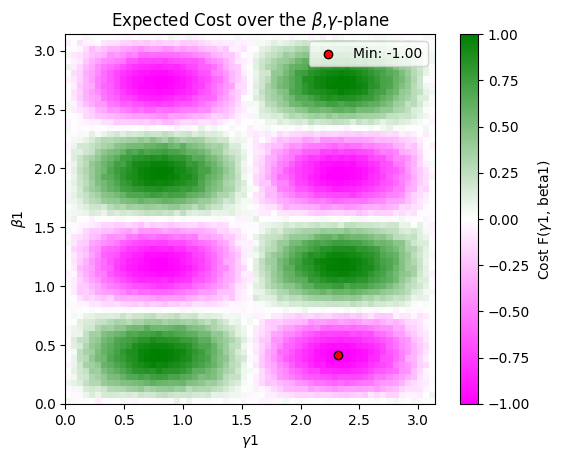

In [ ]:
#plotting The result


# 自定义绿色到粉色的渐变
from matplotlib.colors import LinearSegmentedColormap
colors = ["magenta", "white", "green"]
cmap = LinearSegmentedColormap.from_list("green_to_pink", colors)

# 绘制热力图
plt.imshow(opt_vals, origin='lower', cmap=cmap, extent=(0, np.pi, 0, np.pi), vmin=-1, vmax=1)
plt.colorbar(label="Cost F($\gamma$1, beta1)")



# Find the minimum value and its location
min_idx = np.unravel_index(np.argmin(opt_vals), opt_vals.shape)
min_val = opt_vals[min_idx]

# Calculate the corresponding coordinates
x_extent = (0, np.pi)
y_extent = (0, np.pi)
x_min = x_extent[0] + min_idx[1] * (x_extent[1] - x_extent[0]) / opt_vals.shape[1]
y_min = y_extent[0] + min_idx[0] * (y_extent[1] - y_extent[0]) / opt_vals.shape[0]

# Overlay the minimum point
plt.scatter(x_min, y_min, color='red', label=f"Min: {min_val:.2f}", edgecolor='black')
plt.legend()



plt.ylabel(r'$\beta$1')
plt.xlabel(r'$\gamma$1')
plt.title(r'Expected Cost over the $\beta$,$\gamma$-plane')

In [ ]:
# calculate the minimum cost
